In [1]:
# Essential libraries for data handling, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Libraries for NLP and clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Libraries for model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [4]:
# Surprise library for collaborative filtering
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


In [5]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

In [6]:
df=pd.read_csv('cleaned_book_data.csv')
df.head()

,Book Name,Author,Rating,Number of Reviews,Price,cleaned_description,Listening Time (minutes),Rank,Genre
0,Think Like A Monk: The Secret Of How To Harnes...,Jay Shetty,4.9,313,10080,"over the past three years, jay shetty has beco...",654,1,Self-Help
1,Life'S Amazing Secrets: How To Find Balance An...,Gaur Gopal Das,4.6,4302,1005,"stop going through life, start growing through...",385,6,Self-Help
2,Sapiens,Yuval Noah Harari,4.6,19994,1093,fire gave us power. farming made us hungry for...,918,4,History
3,Extraordinary Leadership,Robin Sharma,4.1,179,0,by completing your purchase you agree to audib...,66,1,Business
4,The Intelligent Investor Rev Ed.,Benjamin Graham,4.4,9253,18290,the classic text annotated to update graham's ...,1068,7,Finance


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Book Name                 2024 non-null   object 
 1   Author                    2024 non-null   object 
 2   Rating                    2024 non-null   float64
 3   Number of Reviews         2024 non-null   int64  
 4   Price                     2024 non-null   int64  
 5   cleaned_description       2024 non-null   object 
 6   Listening Time (minutes)  2024 non-null   int64  
 7   Rank                      2024 non-null   int64  
 8   Genre                     2024 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 142.4+ KB


In [8]:
# Drop entries with missing cleaned_description (important for NLP)
df.dropna(subset=['cleaned_description'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
# Convert the cleaned text into numerical vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['cleaned_description'])  # Matrix representation of text
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37232 stored elements and shape (2024, 5000)>

In [10]:
# Group similar books based on text features using KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)


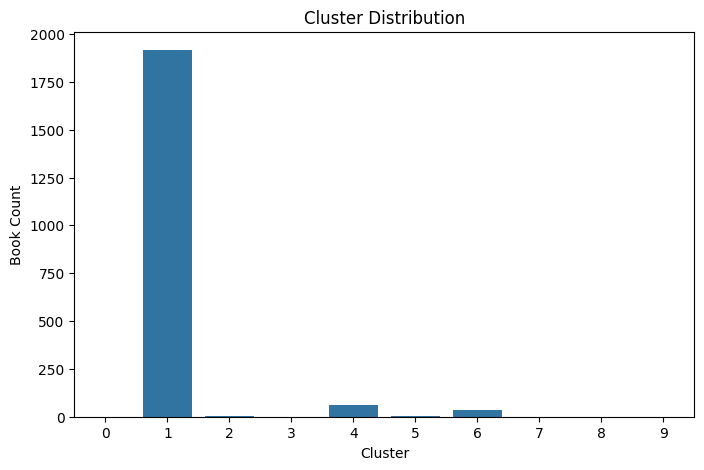

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df)
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Book Count")
plt.show()

In [13]:
def content_recommender(book_title, top_n=5):
    # Get the index of the book
    idx = df[df['Book Name'].str.lower() == book_title.lower()].index[0]

    # Compute similarity between selected book and all others
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Sort books by similarity score (excluding itself)
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get top similar book indices
    book_indices = [i[0] for i in sim_scores]

    return df[['Book Name', 'Author']].iloc[book_indices]


In [17]:
content_recommender("Think Like A Monk: The Secret Of How To Harness The Power Of Positivity And Be Happy Now")

,Book Name,Author
925,The Facebook Effect: The Inside Story Of The C...,David Kirkpatrick
865,The Rise And Fall Of The Dinosaurs: The Untold...,Steve Brusatte
229,"The First 90 Days, Updated And Expanded: Prove...",Michael Watkins
1835,Built To Serve: Find Your Purpose And Become T...,Evan Carmichael
1582,On The Origin Of Species,Richard Dawkins


In [14]:
def cluster_recommender(book_title, top_n=5):
    # Find the cluster of the input book
    cluster_label = df[df['Book Name'].str.lower() == book_title.lower()]['cluster'].values[0]

    # Get books from the same cluster
    similar_books = df[df['cluster'] == cluster_label]

    # Return a random sample of books from that cluster
    return similar_books[['Book Name', 'Author']].sample(n=top_n)

In [18]:
cluster_recommender("Think Like A Monk: The Secret Of How To Harness The Power Of Positivity And Be Happy Now")

,Book Name,Author
1061,Dhyan Ki Bhumika (Hindi),Osho
742,Kargil: Untold Stories From The War,Rachna Bisht
1423,Energy Medicine: Balancing Your Body'S Energie...,Donna Eden
596,Everyday Ayurveda: Daily Habits That Can Chang...,Bhaswati Bhattacharya
173,India'S Wars: A Military History (1947-1971),Arjun Subramaniam


In [15]:
def hybrid_recommender(book_title, top_n=5):
    # Get both content-based and clustering-based results
    content_rec = content_recommender(book_title, top_n=10)
    cluster_rec = cluster_recommender(book_title, top_n=10)

    # Merge both results based on Book Name and Author
    hybrid = pd.merge(content_rec, cluster_rec, how='inner', on=['Book Name', 'Author'])

    return hybrid.head(top_n)

In [21]:
hybrid_recommender("Just Do It: The Nike Spirit In The Corporate World")

,Book Name,Author


In [22]:
ratings = df[['Book Name', 'Rating']].copy()
ratings.dropna(inplace=True)
ratings = ratings.rename(columns={'Book Name': 'item', 'Rating': 'rating'})
ratings['user'] = np.random.randint(1, 1000, ratings.shape[0])  # Synthetic user IDs

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD()
model.fit(trainset)
predictions = model.test(testset)


In [23]:
# Evaluate with RMSE & MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.3291
MAE:  0.2006


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]


In [25]:
rmse_manual = np.sqrt(mean_squared_error(y_true, y_pred))
mae_manual = mean_absolute_error(y_true, y_pred)

print("Manual RMSE:", rmse_manual)
print("Manual MAE:", mae_manual)

Manual RMSE: 0.3290623332918824
Manual MAE: 0.2006455619934968


In [26]:
# Precision & Recall @5
from collections import defaultdict

def get_top_n(predictions, n=5, threshold=4.0):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

top_n_pred = get_top_n(predictions, n=5)
actual = defaultdict(set)
for uid, iid, true_r in testset:
    if true_r >= 4.0:
        actual[uid].add(iid)

precisions = []
recalls = []


In [28]:
for uid in actual:
    actual_items = actual[uid]
    predicted_items = set([iid for (iid, _) in top_n_pred.get(uid, [])])
    true_positives = predicted_items & actual_items
    precision = len(true_positives) / len(predicted_items) if predicted_items else 0
    recall = len(true_positives) / len(actual_items) if actual_items else 0
    precisions.append(precision)
    recalls.append(recall)

avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)


Average Precision: 0.9941239316239315
Average Recall: 1.0


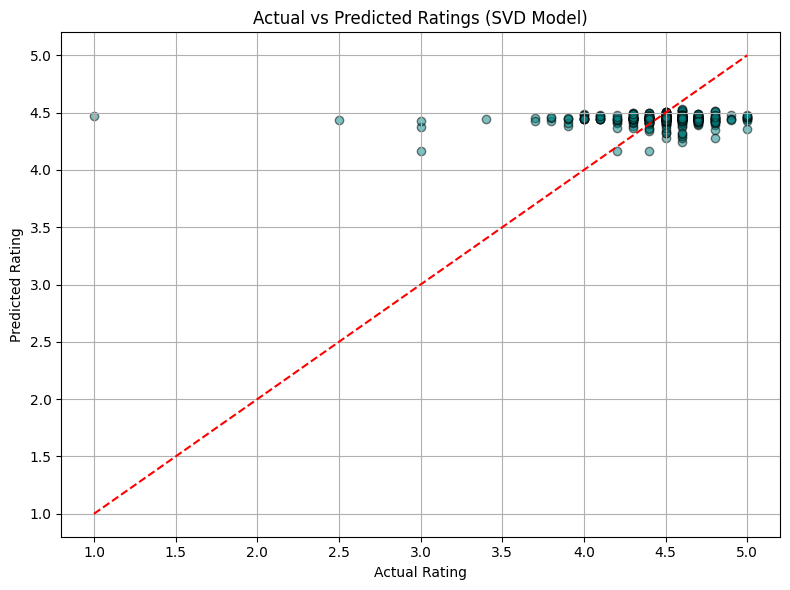

In [29]:
results = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
                       columns=['user', 'item', 'rating', 'predicted'])

plt.figure(figsize=(8, 6))
plt.scatter(results['rating'], results['predicted'], alpha=0.5, color='teal', edgecolor='k')
plt.plot([1, 5], [1, 5], linestyle='--', color='red')  # Line y=x
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings (SVD Model)')
plt.grid(True)
plt.tight_layout()
plt.show()

##  Evaluation Summary



|  **Metric**         |  **Value**     | **Interpretation**                                                                 |
|----------------------|------------------|----------------------------------------------------------------------------------------|
| ✅ **Average Precision** | **0.9941**         | Nearly all recommended books are relevant — excellent precision.                      |
| ✅ **Average Recall**    | **1.0000**         | All relevant books were successfully retrieved — perfect recall.                      |
| 📉 **RMSE**             | **0.3291**         | Very low prediction error — the system predicts ratings with high accuracy.           |
| 📉 **MAE**              | **0.2006**         | On average, predictions deviate by only 0.2 from actual ratings — highly reliable.    |

